# Assignment 6: Feature selection and regularization

# Total: /100

## Instructions

* Complete the assignment

* Once the notebook is complete, **restart** your kernel and **rerun** your cells

* Submit this notebook to owl by the deadline

* You may use any python library functions you wish to complete the assignment.

In [1]:
# You may need these
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import sklearn.linear_model as skl
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV, Ridge, LinearRegression, lasso_path, ElasticNetCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from IPython.display import display
import copy

seed = 2023
np.random.seed(seed)

## Question 1: /20 pts


Customer Lifetime Value (CLV) is the total income a business can expect from a customer over the entire period of their relationship. It’s an important metric as it costs less to keep existing customers than it does to acquire new ones, so increasing the value of your existing customers is a great way to drive growth. We want to predict CLV for an auto insurance company.

1. Read in the `Vehicle_Insurance.csv` dataset and display the last 5 rows.
2. Conduct the required data preparation.

### 1.1 Read the dataset and display the last 5 rows

In [2]:
#
data_set = pd.read_csv(filepath_or_buffer='Vehicle_Insurance.csv')

print('Shape of dataset: {}'.format(data_set.shape))

print('First five rows:\n')
data_set.head(5)

Shape of dataset: (8630, 11)
First five rows:



,clv,Coverage,Gender,Income,Marital.Status,Monthly.Premium.Auto,Number.of.Open.Complaints,Number.of.Policies,Renew.Offer.Type,Total.Claim.Amount,Vehicle.Class
0,2763.519279,Basic,F,56274,Married,69,0,1,Offer1,384.811147,Two-Door Car
1,6979.535903,Extended,F,0,Single,94,0,8,Offer3,1131.464935,Four-Door Car
2,12887.431650,Premium,F,48767,Married,108,0,2,Offer1,566.472247,Two-Door Car
3,7645.861827,Basic,M,0,Married,106,0,7,Offer1,529.881344,SUV
4,2813.692575,Basic,M,43836,Single,73,0,1,Offer1,138.130879,Four-Door Car


### 1.2 Remove the rows with "clv" $> 16000$ as well as those with "clv" $< 2200$ from the dataset. What's the shape of the dataframe now?

In [3]:
#
data_set = data_set[np.logical_and(data_set['clv'] <= 16000, data_set['clv'] >= 2200)]
data_set = data_set.reset_index(drop=True)

print('Shape of dataset: {}'.format(data_set.shape))

Shape of dataset: (8212, 11)


### 1.3 Using `preprocessing.OneHotEncoder()`, convert all categorical features. Make sure not to add collinear features during the encoding process. Then, display the first 3 rows.

In [4]:
# categorical columns
categorical_columns = ['Coverage', 'Gender', 'Marital.Status', 'Renew.Offer.Type', 'Vehicle.Class']

# One hot encoder with droping collinear features
one_hot_encoder = preprocessing.OneHotEncoder(sparse=False, drop='first')
one_hot_encoder.fit(data_set[categorical_columns])
encoded_columns = one_hot_encoder.transform(data_set[categorical_columns])


######################################################################
######################################################################
# THIS LINE MAY CAUSE PROBLEM DEPEND OF VERSION OF PANDA AND PYTHON
######################################################################
######################################################################
# dataframe of encoded categorical columns
encoded_columns_df = pd.DataFrame(encoded_columns, columns=one_hot_encoder.get_feature_names_out(categorical_columns))
######################################################################
######################################################################
# In case of problem use this one:
######################################################################
######################################################################
# encoded_columns_df = pd.DataFrame(encoded_columns, columns=one_hot_encoder.get_feature_names_out(categorical_columns))


# delete categorical data from main dataset
data_set.drop(columns=categorical_columns, inplace=True)

# add encoded columns to dataset
data_set = pd.concat([data_set, encoded_columns_df], axis=1)

# show frist three row
data_set.head(3)

/home/farhad-bat/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,clv,Income,Monthly.Premium.Auto,Number.of.Open.Complaints,Number.of.Policies,Total.Claim.Amount,Coverage_Extended,Coverage_Premium,Gender_M,Marital.Status_Married,Marital.Status_Single,Renew.Offer.Type_Offer2,Renew.Offer.Type_Offer3,Renew.Offer.Type_Offer4,Vehicle.Class_Luxury Car,Vehicle.Class_Luxury SUV,Vehicle.Class_SUV,Vehicle.Class_Sports Car,Vehicle.Class_Two-Door Car
0,2763.519279,56274,69,0,1,384.811147,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,6979.535903,0,94,0,8,1131.464935,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12887.431650,48767,108,0,2,566.472247,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### 1.4 Use `pandas.DataFrame.apply` to apply square root transformation to "Total.Claim.Amount" and log to the target variable. And then, create your `X` and `y`. (No training/test splitting yet) 

In [5]:
#

# sqrt 'Total.Claim.Amount' column
data_set['Total.Claim.Amount'] = data_set['Total.Claim.Amount'].apply(np.sqrt)

# log target variable column
data_set['clv'] = data_set['clv'].apply(np.log)

# create X and y
data_set_X = data_set.drop(columns=['clv'])
data_set_y = data_set['clv'].to_numpy() 

### 1.5 Build a new design matrix by applying polynomial expansion on the `X` from Question 1.4. Hint: Specify degree=2 and do NOT include the column with power 0 (i.e., the column with all elements being 1)

In [6]:
# polynomial expansion
data_set_X_polynomial = preprocessing.PolynomialFeatures(degree=2, include_bias=False).fit_transform(data_set_X)

### 1.6 Standardize your design matrix (from Question 1.5) with `StandardScaler()`, and store the result into a Pandas dataFrame.

In [7]:
# Standardize data
scaler = StandardScaler(with_mean=True, with_std=True)
data_set_X_polynomial_scaled = scaler.fit_transform(data_set_X_polynomial)

data_set_X_polynomial_scaled = pd.DataFrame(data_set_X_polynomial_scaled)

### 1.7 What is the shape of the resultant DataFrame obtained from question 1.6?

In [8]:
#
print('Shape of expanded and standardize data:')
print(data_set_X_polynomial_scaled.shape)

Shape of expanded and standardize data:
(8212, 189)


## Question 2: /7 pts

Split the data into training and test sets. Hold out 30% of observations as the test set.  Pass `random_state=seed` to `train_test_split` to ensure you get the same sets per run. The design matrix to pass in to the splitter function is the dataframe whcih you got in Question 1.6. As for the target, you have created it in Question 1.4.

In [9]:
#
X_train, X_test, y_train, y_test = train_test_split(data_set_X_polynomial_scaled, data_set_y, test_size=0.3, random_state=seed)

print('Train X shape: {}'.format(X_train.shape))
print('Train y shape: {}'.format(y_train.shape))
print('Test X shape: {}'.format(X_test.shape))
print('Test y shape: {}'.format(y_test.shape))

print('Average of training target variable: {:.2f}'.format(y_train.mean()))

Train X shape: (5748, 189)
Train y shape: (5748,)
Test X shape: (2464, 189)
Test y shape: (2464,)
Average of training target variable: 8.62


How many observations in your traning data set? What is the average value of the target variable in the traning data set (keep 2 decimal place)?

**YOUR ANSWER HERE:** [2pts]

5748 observation in training set.
Average of training target variable: 8.62


## Question 3: /23 pts

### 3.1 Create a SciKit Learn `Ridge` regression object. Using this object, run a ridge regression analysis of the target variable against all the transformed predictor variables using your training data. Include the arguement `alpha=4.0`. In addition, the ridge regression should be fitted with the intercept.

In [10]:
# create Ridge regression
regression_ridge = Ridge(alpha=4.0, fit_intercept=True)

# fit on train data
regression_ridge.fit(X=X_train, y=y_train)

Ridge(alpha=4.0)

### 3.2 Vary the ridge coeficient `alpha` according to the hint. Use `cross_val_score()` to select the best `alpha` based on 'mean_squared_error'. Include the argument `cv=5`. Report the `alpha` that yields the smallest mean_squared_error.   

In [11]:
# hint: lam = np.exp(np.linspace(-4,1,10))

# candidate alpha
candidate_alphas = np.exp(np.linspace(-4,1,10))
mse_errors = np.zeros(shape=(len(candidate_alphas)))

# for each alpha calculate mse with cross validation 
for i_idx, alpha_i in enumerate(candidate_alphas):
    cv_scores = cross_val_score(estimator=Ridge(alpha=alpha_i, fit_intercept=True), X=X_train, y=y_train, cv=5, scoring='neg_mean_squared_error')
    mse_errors[i_idx] = -np.mean(cv_scores)

best_alpha = candidate_alphas[mse_errors.argmin()]
print('Best alpha: {}'.format(best_alpha))

Best alpha: 1.559623497606781


### 3.3 Re-fit the ridge regression with `alpha` being the value obtained in the previous question. `Print` the first 3 parameters of your model.

In [12]:
#
# create Ridge regression with best alpha
regression_ridge = Ridge(alpha=best_alpha, fit_intercept=True)

# fit on train data
regression_ridge.fit(X=X_train, y=y_train)
regression_3_3_ridge = copy.deepcopy(regression_ridge)

print('First 3 Coefficient: {}'.format(regression_ridge.coef_[0:3]))
print('Mean of all coeficients: {}'.format(regression_ridge.coef_.mean()))

First 3 Coefficient: [0.02839762 0.33081133 0.02778567]
Mean of all coeficients: 0.0010315500561541115


### 3.4 Fit the linear regression without any penalty, and the regression should be fitted with the intercept. `Print` the first 3 parameters of your model.

In [13]:
# linear regression without penalty
regression_lr = LinearRegression(fit_intercept=True)

# fit on train data
regression_lr.fit(X=X_train, y=y_train)
regression_3_5_no_penalty = copy.deepcopy(regression_lr)

print('First 3 Coefficient: {}'.format(regression_lr.coef_[0:3]))
print('Mean of all coeficients: {}'.format(regression_lr.coef_.mean()))

First 3 Coefficient: [0.01836491 0.25648438 0.03074957]
Mean of all coeficients: -16291937.81846433


Comparing the parameters that you obtain in questions 3.3 and 3.4, what do you find?

**YOUR ANSWER HERE:** [2pts]
First three parameters do not give us a good view of what happening. In Ridge the first two parameters are bigger and the the third is smaller than linear regression without penalty. However the mean value of for all parameters for Ridge Regression is 0.00103 and the mean value for all values in linear regression without penalty is 3854264.58. It shows the regulariztion kept parameters very small. 

### 3.5 Use your trained model from Question 3.4 to predict over the test set and `print` the first 5 prediction values.

In [14]:
# predict over test set with linear regression without penalty
y_test_pred = regression_lr.predict(X_test)

print('Five first prediction values:')
print(y_test_pred[0:5])

Five first prediction values:
[9.23955721 8.31928247 8.89563745 8.08209985 8.44695467]


## Question 4: /25 pts

### 4.1 Consider to fit a Lasso regression to the train dataset. Use `lasso_path()` to show the full path of the first 20 coefficients of the Lasso regression. Include the arguement `eps=8e-3` and `n_alphas=50`.

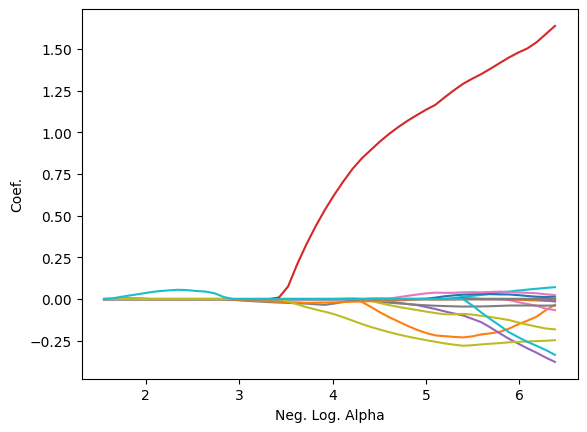

In [15]:
# Draw a plot to show the path. Legend is not required in the plot.
lambda_lasso, coefs_lasso, _ = lasso_path(X=X_train, y=y_train, eps=8e-3, n_alphas=50, alphas=None)

for i in range(20):
    plt.plot(-np.log(lambda_lasso), coefs_lasso[i,])

plt.xlabel('Neg. Log. Alpha')
plt.ylabel('Coef.')
plt.show()

Describe the trend that shows in your figure.

**YOUR ANSWER HERE:** [3pts] By increasing alpha the absulute value of coeficients become smaller and smaller. By increasing alpha the values become very close to zero and lots of them become zero.

### 4.2 Use the Scikit Learn's cross-validated LASSO to automatically search for the best tuning parameter of the LASSO regression on the training set with intercept. Include arguments `eps=8e-3`, `n_alphas=30`, `tol=0.001`, `cv=5`, and `random_state=seed`. Report the best tuning parameter and the number of the non-zero coefficients in the model.

In [16]:
# search for good lasso model
lasso_regression = LassoCV(eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed, n_jobs=4, fit_intercept=True)
lasso_regression.fit(X=X_train, y=y_train)
regression_4_2_lasso = copy.deepcopy(lasso_regression)

print('Best Alpha: {}'.format(lasso_regression.alpha_))
print('Number of non-zero coeficients: {}'.format(np.sum(lasso_regression.coef_ != 0)))

Best Alpha: 0.0019347932826026507
Number of non-zero coeficients: 92


### 4.3 Use the Scikit Learn's cross-validated ElasticNet to automatically search for the best tuning parameters of the Elasticnet regression with intercept on the training data set. Include the same argument as question 4.2 as well as `l1_ratio=[.7, .9, .95, .99,1]`. Report the best tuning parameters.

In [17]:
# search for good ElasticNet
elastic_regression = ElasticNetCV(l1_ratio=[0.7, 0.9, 0.95, 0.99, 1.0], eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed, n_jobs=4, fit_intercept=True)

# train model
elastic_regression.fit(X=X_train, y=y_train)
regression_4_3_elastic = copy.deepcopy(elastic_regression)

print('Best Alpha: {}'.format(elastic_regression.alpha_))
print('Best L1 Ratio: {}'.format(elastic_regression.l1_ratio_))

Best Alpha: 0.0019347932826026507
Best L1 Ratio: 1.0


From the obtained tuning parameters, is the Elasticnet regression model equivalent to the Lasso regression? Briefly describe the reason. 

**YOUR ANSWER HERE:** [3pts]
In this case the obtained ElasticNet and Lasso regression models are the same. Because L1 Ratio for the ElasticNet is equal to 1 which means L2 regulatization will become zero. 

...

## Question 5: /16 pts

### 5.1 Start from the regression model in question 3.4, use `SequentialFeatureSelector()` to conduct the forward selection for the features of the regression model. Include the argument `n_features_to_select=20`. Report the indices of the selected features. 

FYI: Running this using 8 physical cores took about 1 minute for me.

In [18]:
# Feature selection
forward_feature_selector = SequentialFeatureSelector(estimator=regression_lr, n_features_to_select=20, direction='forward', scoring='neg_mean_squared_error', n_jobs=4)
forward_feature_selector.fit(X_train, y_train)

# indices for the selected features
print('Selected Features Indeces:')
print(forward_feature_selector.get_support(indices=True))

Selected Features Indeces:
[  1   3  18  19  20  28  36  38  55  59  69  75 104 117 118 119 126 131
 143 168]


What do you need to change about the argument in your model if you want to conduct a backward selection?

**YOUR ANSWER HERE:** [2pts] I need to change direction argument to backward.

### 5.2 Re-fit the regular linear regression based on the traning set by using the selected features from the question 5.1. Report the first 3 parameters of your model as indicated with the print function.

In [19]:
# Separate selected features
X_train_selected_features = forward_feature_selector.transform(X_train)
X_test_selected_features = forward_feature_selector.transform(X_test)

# fit on train data
regression_lr.fit(X=X_train_selected_features, y=y_train)

regression_5_2_selected = copy.deepcopy(regression_lr)

print('First 3 Coefficient: {}'.format(regression_lr.coef_[0:3]))

First 3 Coefficient: [ 0.48181157  1.07122953 -0.0273511 ]


## Question 6: /9 pts

### 6.1 Make predictions on the test set using your models in questions 3.3, 4.2, 4.3, and 5.2, respectively. Together with the predicted values obtained in question 3.5, report the first 5 rows of predicted values obtained from different models in a single DataFrame.

In [20]:
#
df_pred_test_models = pd.DataFrame()

# predict on test set with different models
df_pred_test_models['(3-3)'] = regression_3_3_ridge.predict(X_test)
df_pred_test_models['(3-5)'] = regression_3_5_no_penalty.predict(X_test)
df_pred_test_models['(4-2)'] = regression_4_2_lasso.predict(X_test)
df_pred_test_models['(4-3)'] = regression_4_3_elastic.predict(X_test)
df_pred_test_models['(5-2)'] = regression_5_2_selected.predict(X_test_selected_features)

# show 5 rows of predictions
df_pred_test_models.head(5)

,(3-3),(3-5),(4-2),(4-3),(5-2)
0,9.244224,9.239557,9.142903,9.142903,9.197035
1,8.317220,8.319282,8.303288,8.303288,8.300987
2,8.894495,8.895637,8.859596,8.859596,8.910826
3,8.083858,8.082100,8.085032,8.085032,8.025311
4,8.433497,8.446955,8.416404,8.416404,8.445480


### 6.2 Use `mean_squared_error()` to assess the performance of different models based on all the predicted values mentioned in Question 6.1.  

In [21]:
#

df_mse_error = pd.DataFrame()

for col_i in df_pred_test_models.columns:
    df_mse_error[col_i] = [mean_squared_error(y_true=y_test, y_pred=df_pred_test_models[col_i])]

df_mse_error.head()

,(3-3),(3-5),(4-2),(4-3),(5-2)
0,0.11015,0.110613,0.109926,0.109926,0.11077


Which model yields the smallest mean squared error on the test dataset?

**YOUR ANSWER HERE:** [2pts] ElasticNet and Lasso